<a href="https://colab.research.google.com/github/Siahkamari/Portfolio-Optimization-via-Expert-Algorithms/blob/master/portfolio_selection_with_google_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import lxml
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

In [2]:
## Read data
dates = ['02/07/2022','02/18/2022']

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

## ticker_list
worksheet = gc.open('stock_list').sheet1
print(worksheet)
cells = worksheet.range('B1:AZ3')

ticker_list = []
quantity = []
for i, cell in enumerate(cells):
  if i<  len(cells)/3:
    ticker_list.append(cell.value)
  elif i < (2*len(cells))/3:
    quantity.append(cell.value)

df_quantity = pd.DataFrame(columns=np.array(ticker_list), data= np.array(quantity).reshape(1,-1), index = [dates[0]])


<Worksheet 'Sheet1' id:1867415061>


In [3]:
df_quantity.head()

,AAPL,ABBV,AGTI,AVGO,BHF,CDW,CMS,CRAI,CSCO,EXP,...,UBA,USLM,XBIT,LKQ,UTMD,DE,DKNG,G,IT,SPY
02/07/2022,16,9,50,2,,5,,,20,,...,50,,None,None,None,,,,,


In [4]:
def get_ticker_data(ticker, silent=False):

  worksheet = gc.open('gf_data').sheet1

  cell = worksheet.range('C3:C4')
  cell[1].value = ticker
  worksheet.update_cells(cell)

  # get_all_values gives a list of rows.
  rows = worksheet.get_all_values()

  # Convert to a DataFrame and render.
  import pandas as pd
  df = pd.DataFrame.from_records(rows)
  
  # Print summary
  df_summary = df.iloc[:8,:3]

  df_today = pd.DataFrame(np.array([datetime.datetime.strptime(df_summary.iloc[1,2],'%m/%d/%Y'),\
                                  df_summary.iloc[4,2]]).reshape(1,-1),\
                        columns=['Date','Close'])

  if not silent:
    display(df_summary)

  # Read historical
  df_prices = df.iloc[8:,:3]
  df_prices.columns = df_prices.iloc[0]
  df_prices = df_prices.drop(df_prices.index[0])
  df_prices = df_prices.append(df_today)

  df_prices['Date'] = pd.to_datetime(df_prices['Date'])
  df_prices['Close'] = df_prices['Close'].astype('float32')

  df_prices['Close_l01'] = df_prices['Close'].shift(1).fillna(method='bfill')
  df_prices['changepct'] = (df_prices['Close']-df_prices['Close_l01'])/df_prices['Close_l01']
  df_prices['log_Close'] = np.log(df_prices['Close']) - np.log(df_prices['Close']).iloc[0]
  df_prices['day'] = df_prices['Date'].dt.day

  if not silent:
    display(df_prices.tail())
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1 ,1, 1)
    df_prices.set_index('Date')['Close'].plot(ax=ax, label=ticker)
    ax.legend()
    ax.set_ylabel('Close')


  return df_summary, df_prices

,0,1,2
0,,,
1,,end_date,08/09/2022
2,,start_date,02/07/2022
3,,ticker,THC
4,,price,63.2
5,,marketcap,6.818565922
6,,pe,7.89
7,,datadelay,0


,Date,Close,Volume,Close_l01,changepct,log_Close,day
131,2022-08-03 16:00:00,65.940002,677898,64.919998,0.015712,-0.059750,3
132,2022-08-04 16:00:00,64.070000,846734,65.940002,-0.028359,-0.088519,4
133,2022-08-05 16:00:00,64.370003,723995,64.070000,0.004682,-0.083848,5
134,2022-08-08 16:00:00,64.169998,842256,64.370003,-0.003107,-0.086959,8
0,2022-08-09 00:00:00,63.200001,NaN,64.169998,-0.015116,-0.102191,9


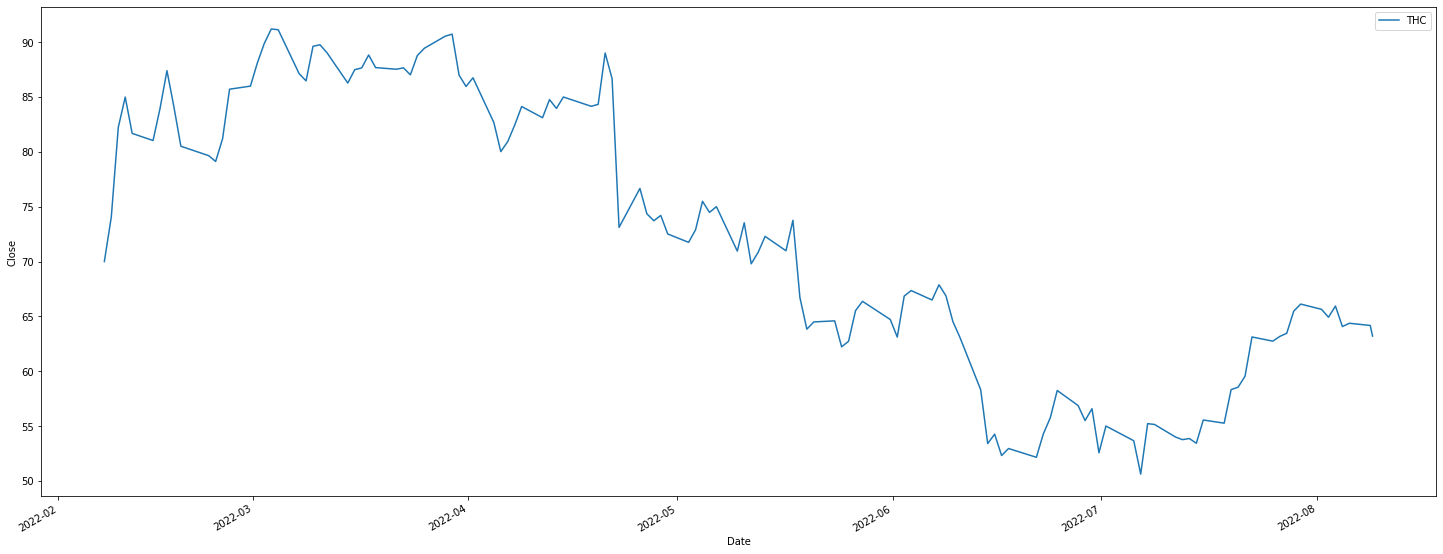

In [5]:
df_summary, df_prices = get_ticker_data('THC')

In [6]:
n = len(ticker_list)
df_all_prices = pd.DataFrame(columns=['Date'])
for i, ticker in enumerate(ticker_list):
    try:
      _, df_prices = get_ticker_data(ticker, silent=True)
      df_prices = df_prices[['Date','Close']].rename(columns={'Close':ticker})
      df_all_prices =  df_all_prices.merge(df_prices, on='Date', how='outer') 
    except:
        print("failed to download ",ticker)

df_all_prices = df_all_prices.set_index('Date')

In [7]:
ticker_list.append('$')
df_quantity['$'] = 1000
df_all_prices['$'] = 1.0
df_all_prices.head()

,AAPL,ABBV,AGTI,AVGO,BHF,CDW,CMS,CRAI,CSCO,EXP,...,USLM,XBIT,LKQ,UTMD,DE,DKNG,G,IT,SPY,$
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-07 16:00:00,171.660004,142.529999,17.520000,587.630005,59.000000,191.309998,64.919998,86.720001,55.169998,141.520004,...,120.300003,10.15,55.040001,93.309998,372.200012,21.500000,48.669998,294.850006,447.260010,1.0
2022-02-08 16:00:00,174.830002,143.509995,17.610001,600.219971,59.680000,194.759995,64.940002,90.169998,55.340000,143.490005,...,121.889999,10.32,55.810001,95.449997,389.880005,22.120001,49.340000,302.660004,450.940002,1.0
2022-02-09 16:00:00,176.279999,143.199997,17.879999,611.340027,59.439999,189.960007,64.820000,91.250000,56.290001,144.440002,...,121.300003,10.39,56.970001,99.660004,395.399994,23.420000,49.750000,302.899994,457.540009,1.0
2022-02-10 16:00:00,172.119995,142.710007,17.760000,591.359985,60.130001,183.369995,62.480000,89.500000,54.869999,143.059998,...,118.099998,10.11,54.880001,94.599998,393.149994,22.780001,48.349998,291.119995,449.320007,1.0
2022-02-11 16:00:00,168.639999,142.009995,17.750000,573.419983,57.299999,178.750000,63.099998,90.139999,53.900002,141.839996,...,117.050003,10.13,53.700001,94.599998,392.670013,23.330000,44.849998,288.750000,440.459991,1.0


In [8]:
def pfe(df_all_prices, x_0, cut_off):

  T = df_all_prices.shape[0]
  n = df_all_prices.shape[1]

  # initialization
  f_digit = np.zeros(T)

  sum_g_tild = np.zeros(n)
  sum_g_tild_w = np.zeros(n)
  # iterations
  for t in range(T-1):
      w = sum_g_tild /(t+1)*(1+sum_g_tild_w)
      x =  x_0 * np.maximum(w, 0)
      if np.sum(x) > 0:
          x = x / np.sum(x)
      else:
          x = x_0

      p_t = df_all_prices.iloc[t,:]
      p_t01 = df_all_prices.iloc[t+1,:]
      r = np.array( (p_t01/p_t).fillna(1).values)
      grad = r/np.dot(x, r)

      g_tild = grad - np.dot(grad, x)
      g_tild[w<0] = np.maximum(g_tild[w<0], 0)

      sum_g_tild += g_tild
      sum_g_tild_w += g_tild*w
      if t == 0:
        f_digit[0] = 0
      else:
        # digitalized wealth
        present = x> cut_off
        x_digit = x[present]
        r_digit = r[present]
        f_digit[t] = -np.log(np.dot(x_digit,r_digit)/sum(x_digit))

  return x, np.cumsum(-f_digit[1:])

In [9]:
def project(y, A):
  n = y.size

  P = matrix(A, tc='d')
  q = matrix(-2*np.matmul(y, A), tc='d')
  G = matrix(-np.eye(n), tc='d')
  h = matrix(np.zeros(n), tc='d')
  A = matrix(np.ones([1,n]), tc='d')
  b = matrix([1], tc='d')

  solvers.options['show_progress'] = False
  sol = solvers.qp(P,q,G,h,A,b)
  return np.array(sol['x']).reshape(-1)

def ons(df_all_prices):
  T = df_all_prices.shape[0]
  n = df_all_prices.shape[1]
  # parameters:
  alpha = 0.5

  # algorithm
  G = np.sqrt(n)/alpha
  gamma = 1/8/G
  epsilon = 1/gamma**2

  # Initialization
  A = epsilon*np.eye(n)
  f = np.zeros(T)

  x = np.ones(n)/n
  # iterations
  for t in range(T-1):
    r = np.array((df_all_prices.iloc[t+1,:]/df_all_prices.iloc[t,:]).fillna(1).values)
    grad = - r/np.dot(x, r)
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

    # log wealth
    f[t] = - np.log(np.dot(x,r))


  return x, np.cumsum(-f[1:])

In [10]:
cut_off = 1e-7

# Current Portfolio
df_quantity = df_quantity.replace('',0.1)
df_quantity = df_quantity.replace('None',0.1)
df_quantity = df_quantity.astype(float)

# x_0
cost_basis = (np.array(df_all_prices.head(1).values)*np.array(df_quantity.values)).reshape(-1)
print('cost_basis =', sum(cost_basis))
x_0 =  cost_basis/sum(cost_basis)


# Parameter Free Expert
x_pfe, log_wealth_expert = pfe(df_all_prices, x_0,  cut_off=cut_off)

# ONS 
x_ons, log_wealth_ons = ons(df_all_prices)

# ONS + Parameter Free Expert
my_etf = ['ONS','PFE']
alg1 = np.exp(log_wealth_expert).reshape(-1,1)
alg2 = np.exp(log_wealth_ons).reshape(-1,1)
etf = np.concatenate((df_all_prices.reset_index()['Date'].dt.day.values.reshape(-1,1),
                      np.append(np.array(1).reshape(-1,1),alg1, axis=0),
                      np.append(np.array(1).reshape(-1,1),alg2, axis=0)), axis = 1)
df_etf = pd.DataFrame(data = etf, columns=['Date']+my_etf)
df_etf = df_etf.set_index('Date')

x_etf , log_wealth_expert_ons = pfe(df_etf, [0.5,0.5], cut_off=cut_off)

cost_basis = 48871.71822977067


In [11]:
def portfolio_plot(x,tickers,cut_off,ax1):
  sizes = []
  labels = []
  for i in range(len(x)):
    if x[i] > cut_off:
      sizes.append(x[i]*100)
      labels.append(tickers[i])
  ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  return ax1

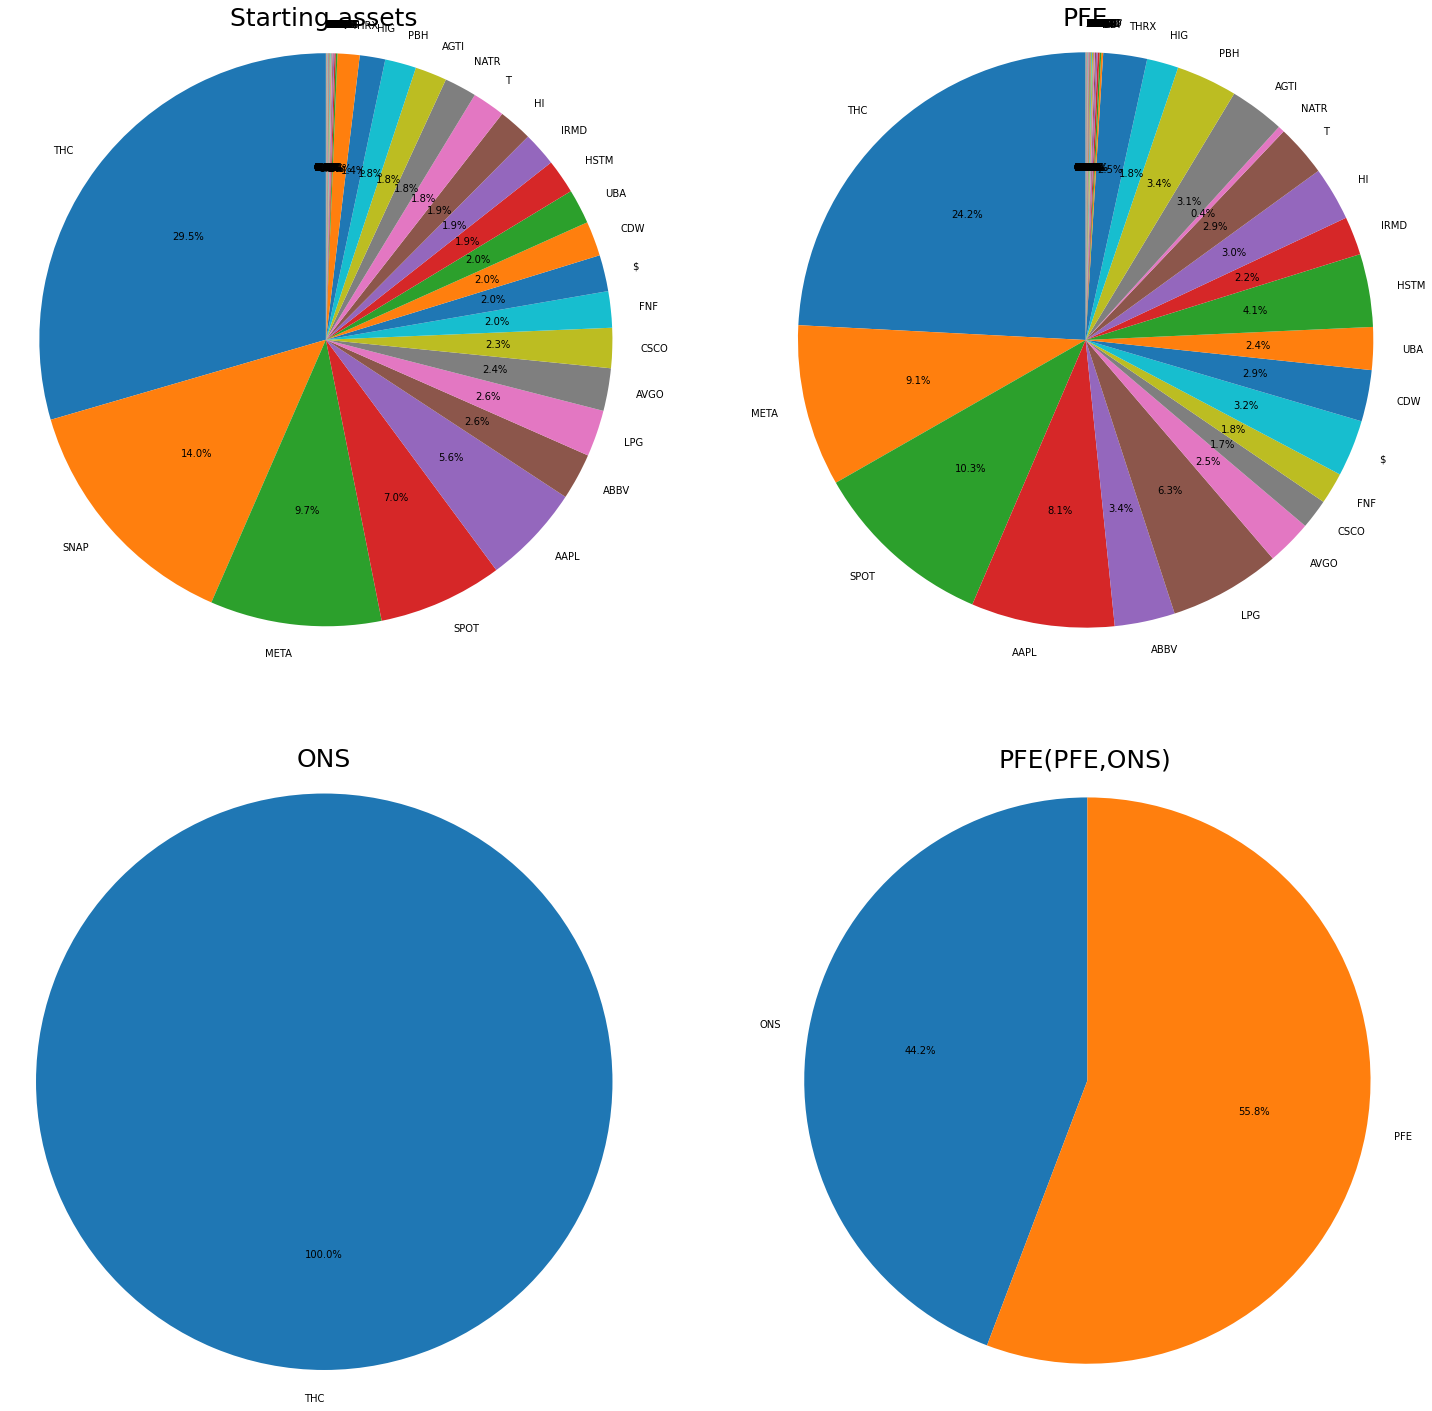

In [12]:
fig1, ax1 = plt.subplots(2,2)
fig1.set_size_inches(25, 25)

I = np.argsort(x_0)[::-1]
ticker_list_sorted = [ticker_list[i] for i in I]

ax1[0,0] = portfolio_plot(x_0[I], ticker_list_sorted,cut_off,ax1[0,0])
ax1[0,0].set_title('Starting assets', {'fontsize': 25})

ax1[0,1] = portfolio_plot(x_pfe[I], ticker_list_sorted,cut_off,ax1[0,1])
ax1[0,1].set_title('PFE', {'fontsize': 25})

ax1[1,0] = portfolio_plot(x_ons[I], ticker_list_sorted,cut_off,ax1[1,0])
ax1[1,0].set_title('ONS', {'fontsize': 25})

ax1[1,1] = portfolio_plot(x_etf, my_etf, cut_off, ax1[1,1])
ax1[1,1].set_title('PFE(PFE,ONS)', {'fontsize': 25})


plt.show()

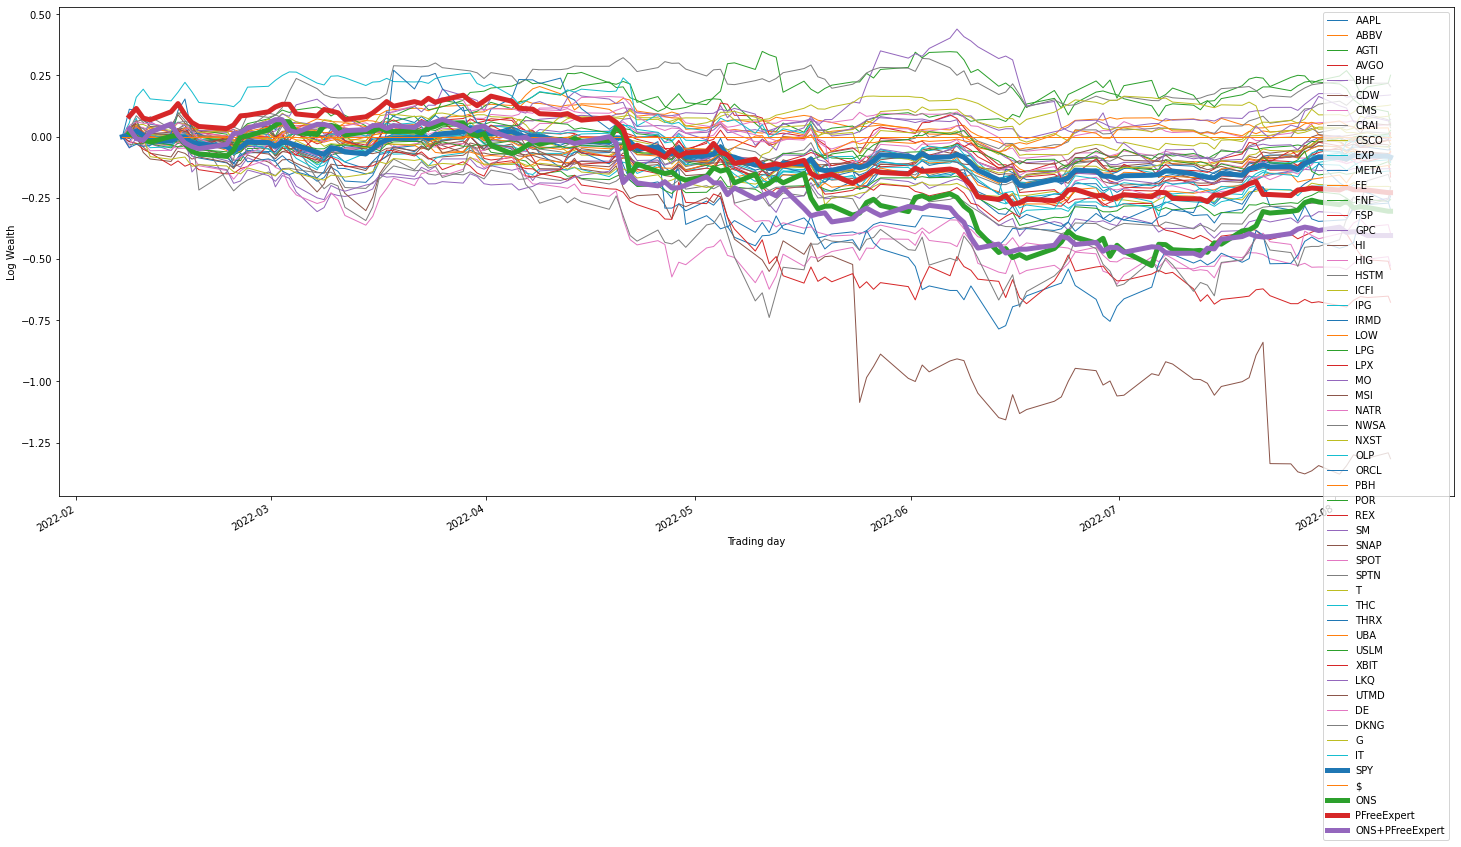

In [13]:
## Historical performance
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1 ,1, 1)

for ticker in ticker_list:
    if ticker == "SPY":
        linewidth = 5
    else:
        linewidth = 1
    (np.log(df_all_prices[ticker])-np.log(df_all_prices[ticker].iloc[0])).plot(ax=ax, label=ticker, linewidth=linewidth)
ax.legend();
ax.set_ylabel('log_Close')

df_ons = pd.DataFrame(data=log_wealth_ons, index=df_all_prices.index[1:], columns=['ONS'])
df_pmf = pd.DataFrame(data=log_wealth_expert, index=df_all_prices.index[1:], columns=['PFreeExpert'])
df_pmfons = pd.DataFrame(data=log_wealth_expert_ons, index=df_all_prices.index[1:], columns=['ONS+PFreeExpert'])
df_ons.plot(ax = ax, linewidth=5)
df_pmf.plot(ax = ax, linewidth=5)
df_pmfons.plot(ax = ax, linewidth=5)

ax.legend()
ax.set_xlabel('Trading day')
ax.set_ylabel('Log Wealth')
plt.show()